Processing data from

https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/

We read in the data and do some basic cleanup for misisng values. For the description of the fields, see

https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.names

In summary:
```
 Sample code number          : Id number (not used and thus dropped)
 Clump Thickness             : 1–10
 Uniformity of Cell Size     : 1–10
 Uniformity of Cell Shape    : 1–10
 Marginal Adhesion           : 1–10
 Single Epithelial Cell Size : 1–10
 Bare Nuclei                 : 1–10
 Bland Chromatin             : 1–10
 Normal Nucleoli             : 1–10
 Mitoses                     : 1–10
 Class                       : 2 for benign, 4 for malignant
```



In [1]:
import pandas as pd
data = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data", header = None)
data = data.drop(data.columns[0], axis=1)
data.head()

1   2   3   4   5   6   7   8   9   10
0   5   1   1   1   2   1   3   1   1   2
1   5   4   4   5   7  10   3   2   1   2
2   3   1   1   1   2   2   3   1   1   2
3   6   8   8   1   3   4   3   7   1   2
4   4   1   1   3   2   1   3   1   1   2


We do some cleanup:

- We replace the missing values of column 6 (with '?') by 0 (to not affect the mean)
- We compute the mean, then replace 0 values by the mean (only we added 0s)
- For replace the targets 2 and 4 by 0 and 1 respectively

In [2]:
df = pd.DataFrame(data)
#print(df)

# Cleanup: replacing ? by 0 (later to be replaced by mean)
df[6] = df[6].replace('?',0)
df[6] = df[6].astype(int)
#df.dtypes

# Cleanup: replacing by mean
mean = int(df[6].mean())
df[6] = df[6].replace(0,mean)

# Re-arranging labels 2 -> 0 and 4 -> 1
df[10] = df[10].replace(2,0).replace(4,1)



Let's have a look at the data, adding labels first

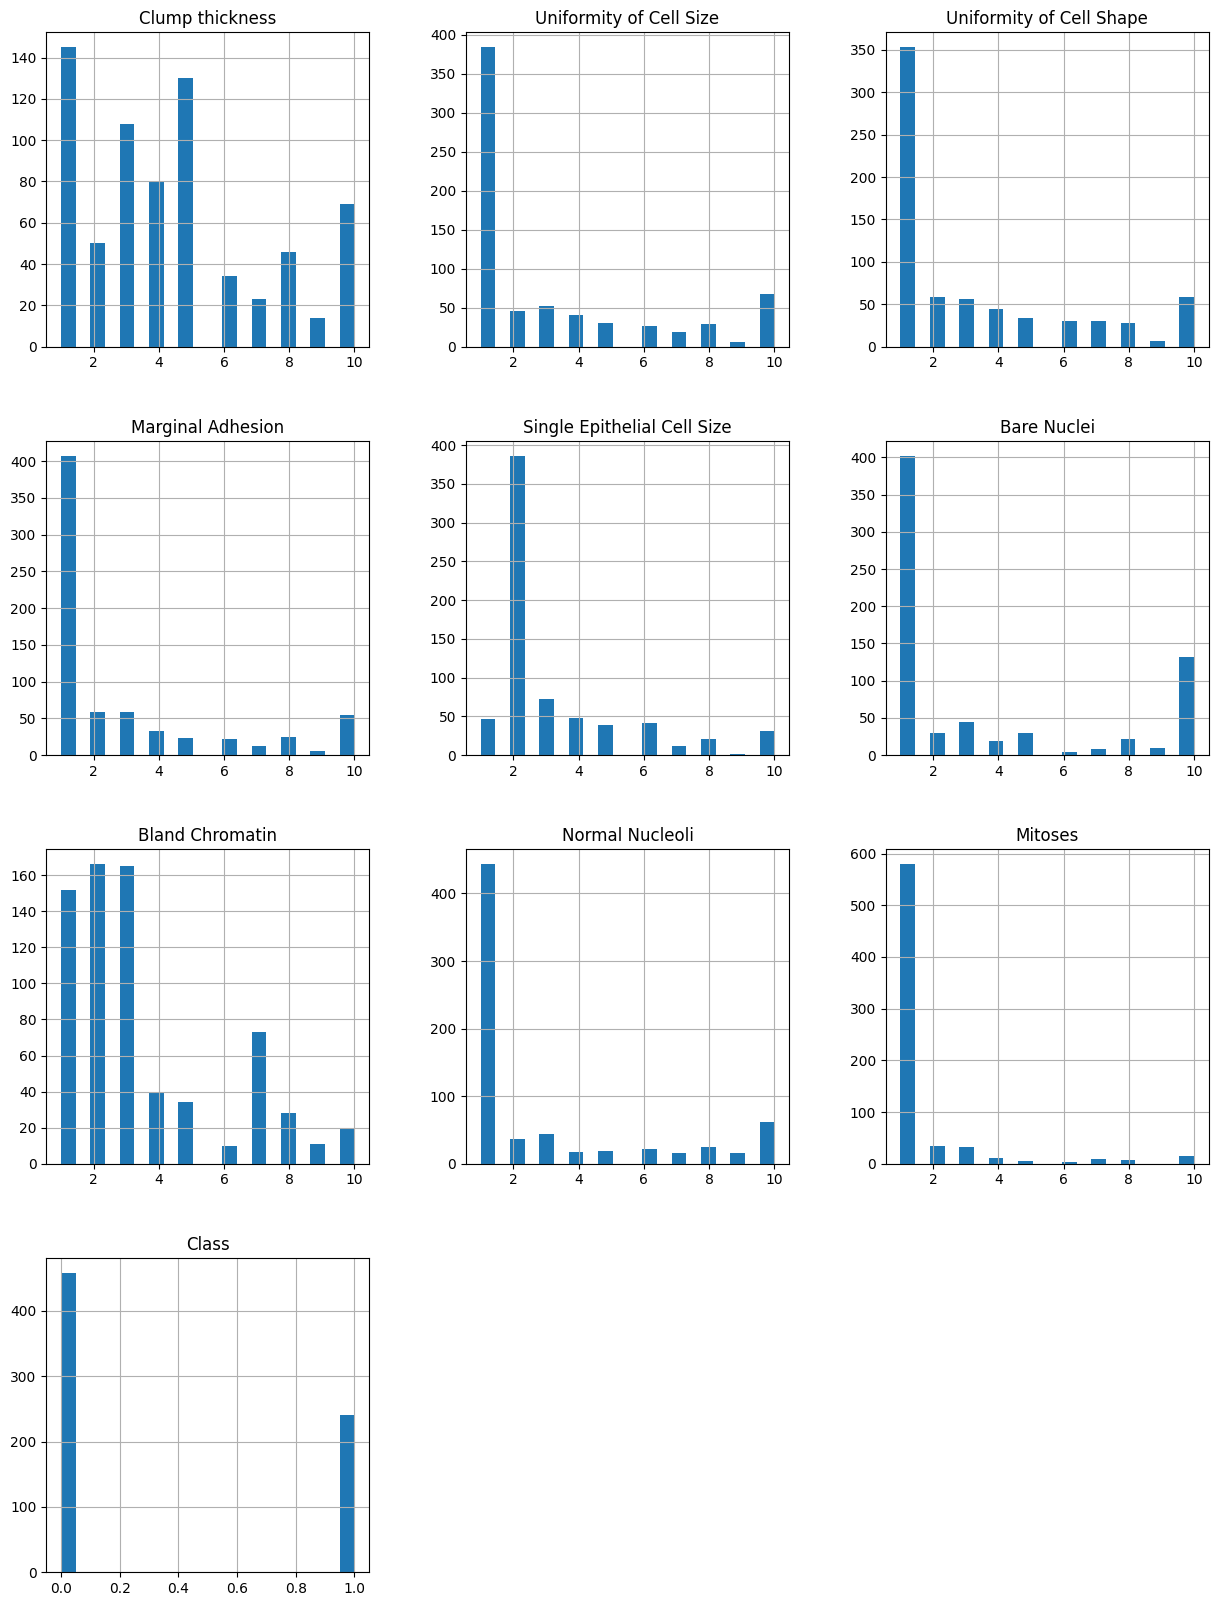

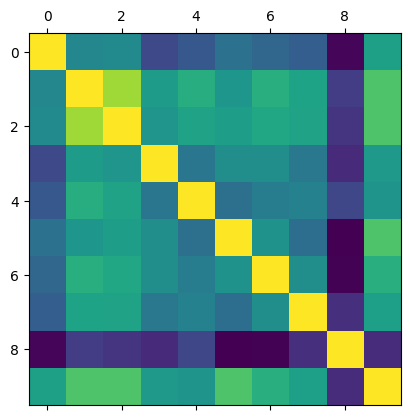

In [3]:
names = [ "ID", "Clump thickness", "Uniformity of Cell Size", "Uniformity of Cell Shape", "Marginal Adhesion", "Single Epithelial Cell Size", "Bare Nuclei", "Bland Chromatin", "Normal Nucleoli", "Mitoses", "Class" ]
df.columns = names[1:]
#print(df)

hists = df.hist(bins=20, figsize=(15,20))

#df.corr()
import matplotlib.pyplot as plt
plt.matshow(df.corr())
plt.show()

Making pair plots to visualize the data

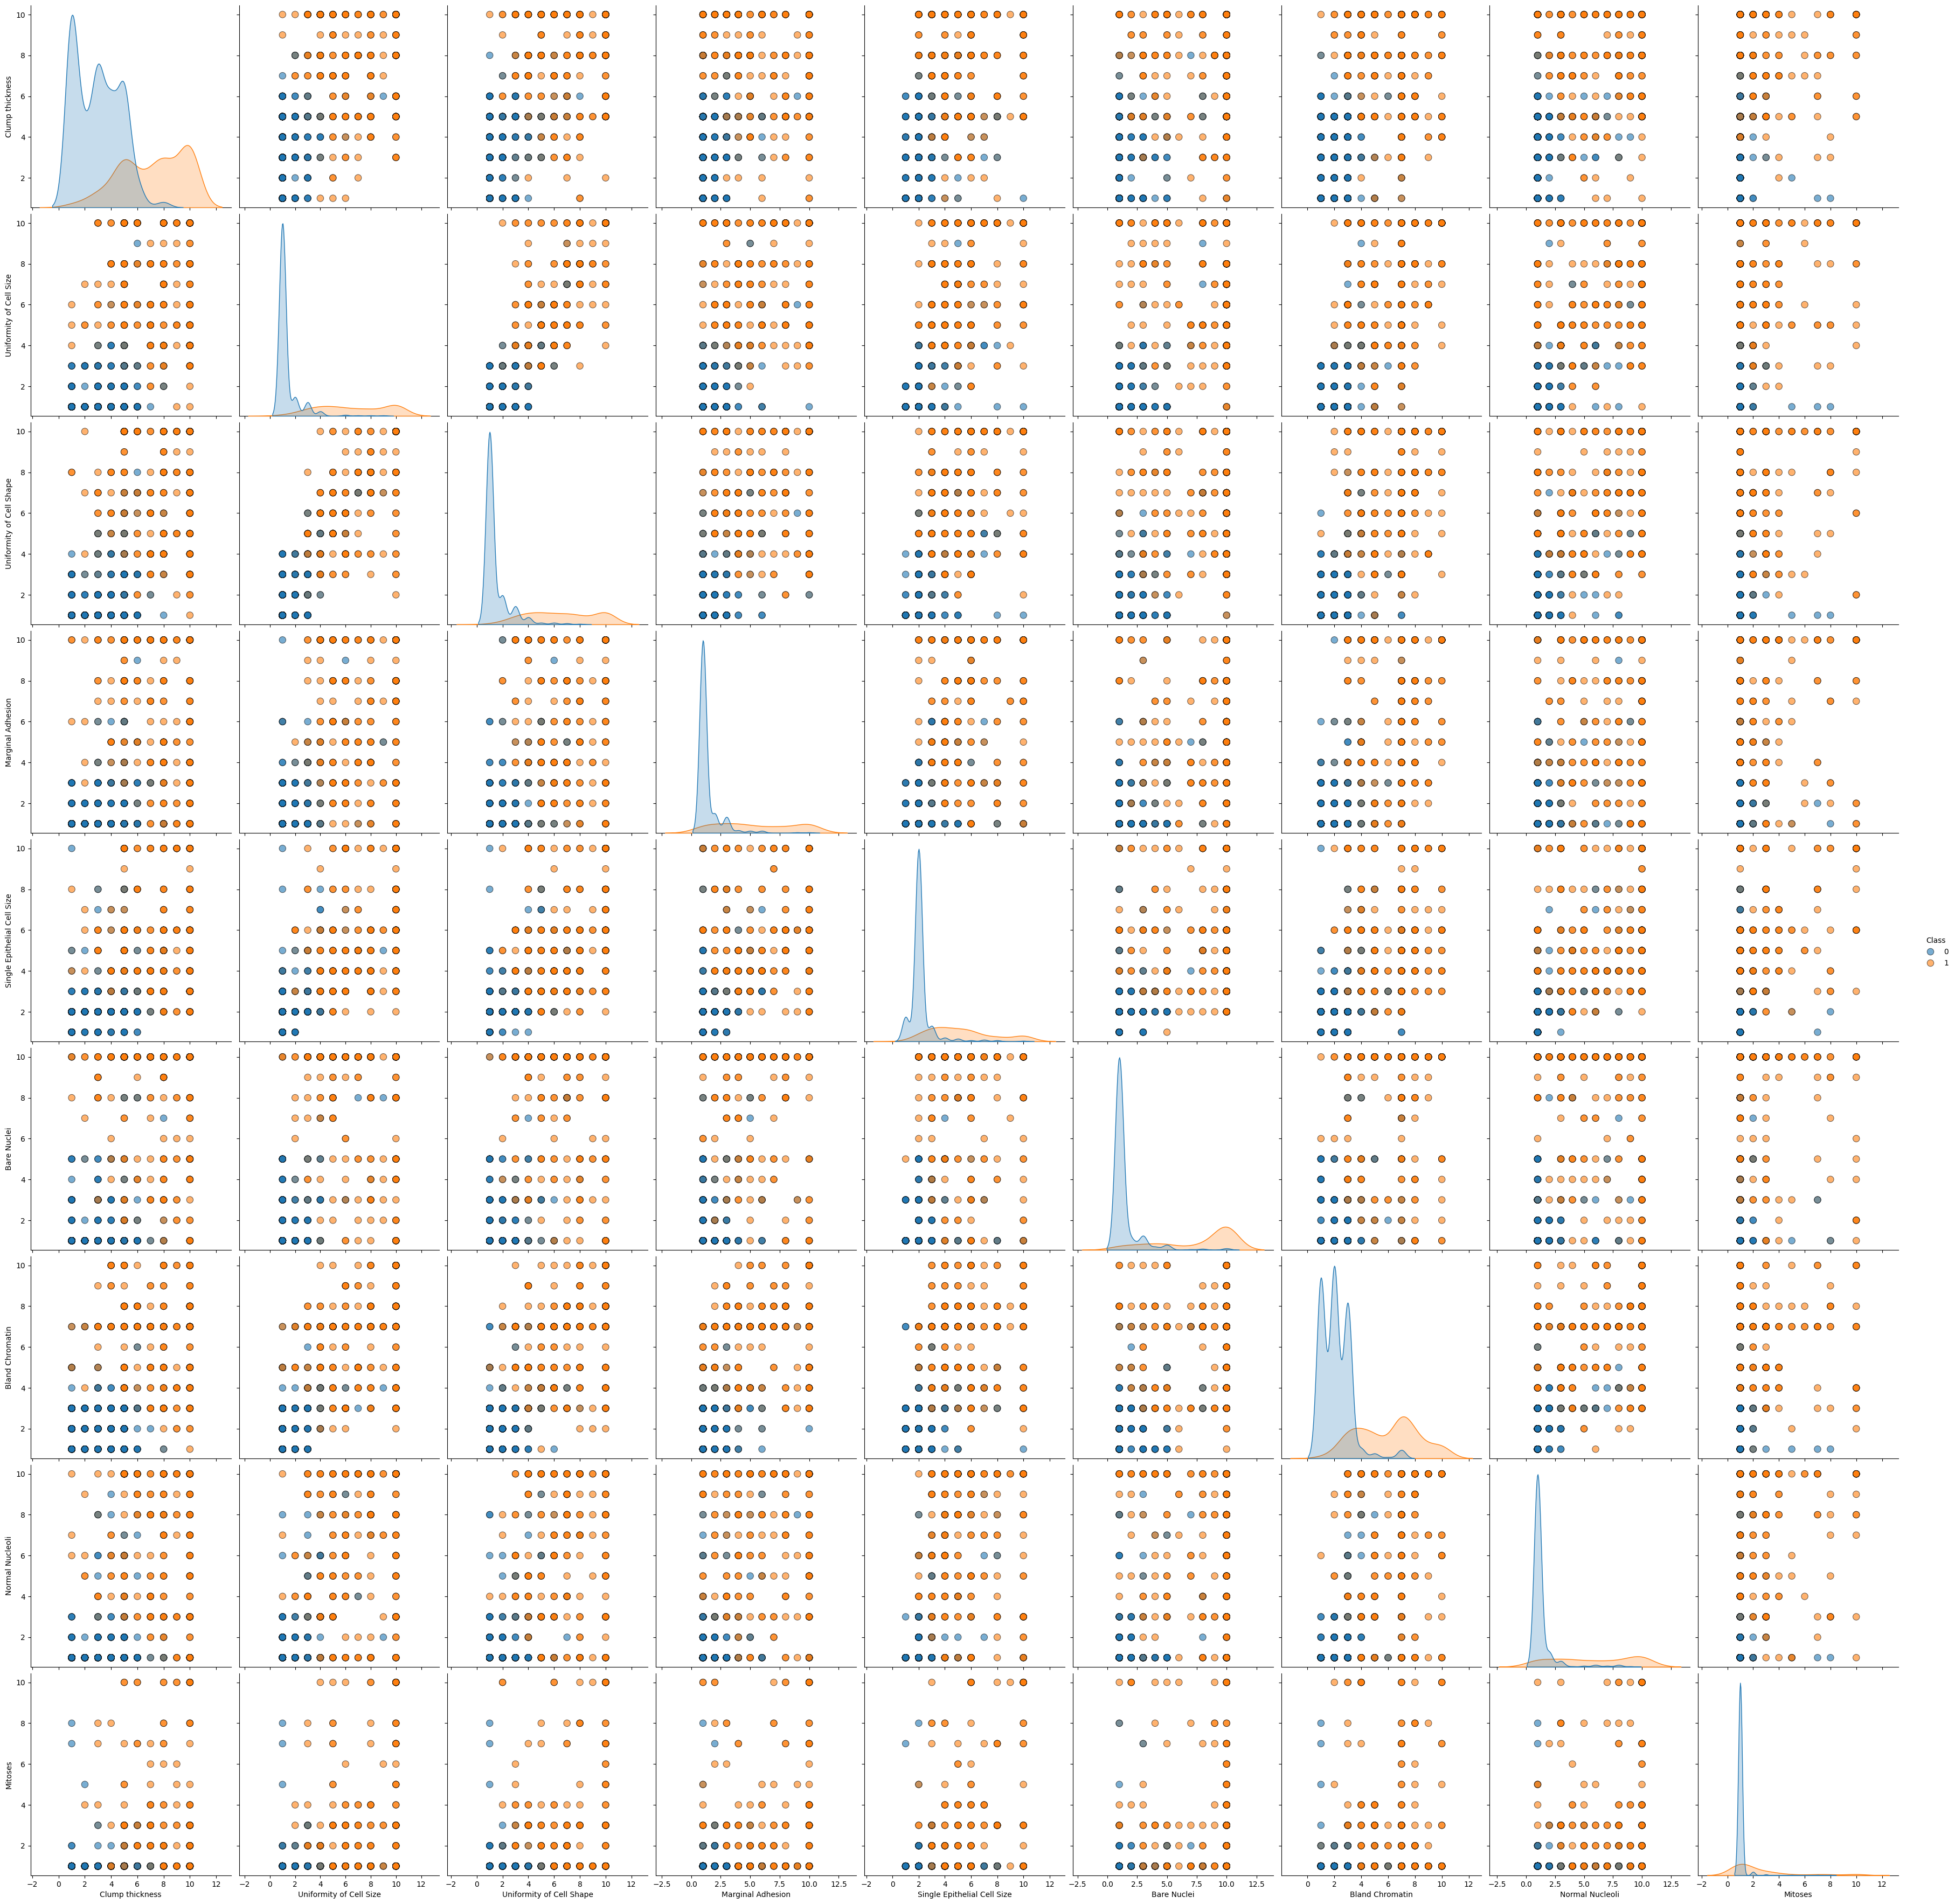

In [4]:
# Seaborn visualization library
import seaborn as sns
# Create the default pairplot
sns.pairplot(df, hue = 'Class', diag_kind = 'kde',
             plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'},
             height = 4)

Splitting our sample into testing and training sets, normalizing each **independently** (why?).

In [5]:
# Using information from all columns (0-9) to predict target (column 10)
X = df.iloc[:, :9]
Y = df.iloc[:, 9]

# Splitting between traning and testing
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

# Checking the shapes to get an understanding of the problem
print( X_train.shape, X_test.shape )
print( Y_train.shape, Y_test.shape )

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

(559, 9) (140, 9)
(559,) (140,)


Setting up our model in Tensorflow:
- 9 input nodes
- 5 nodes in the 1st hidden layer (with ReLU activation)
- 3 nodes in the 2nd hidden layer (with ReLU activation)
- 1 output node (whose value will be the probablity to belong to either class)


In [6]:
import tensorflow as tf

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(5, activation=tf.nn.relu, input_dim=9),
  tf.keras.layers.Dense(3, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1, activation=tf.nn.sigmoid) # Sigmoid to limit output between 0 and 1
])

model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy'])


model.fit(X_train, Y_train, batch_size = 10, epochs=100)

2023-11-30 13:37:16.204493: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
56/56 [==============================] - 1s 2ms/step - loss: 0.3664 - accuracy: 0.4454
Epoch 2/100
56/56 [==============================] - 0s 2ms/step - loss: 0.2750 - accuracy: 0.4705
Epoch 3/100
56/56 [==============================] - 0s 1ms/step - loss: 0.2156 - accuracy: 0.6422
Epoch 4/100
56/56 [==============================] - 0s 1ms/step - loss: 0.1821 - accuracy: 0.8640
Epoch 5/100
56/56 [==============================] - 0s 1ms/step - loss: 0.1635 - accuracy: 0.9392
Epoch 6/100
56/56 [==============================] - 0s 1ms/step - loss: 0.1533 - accuracy: 0.9517
Epoch 7/100
56/56 [==============================] - 0s 1ms/step - loss: 0.1439 - accuracy: 0.9499
Epoch 8/100
56/56 [==============================] - 0s 1ms/step - loss: 0.1350 - accuracy: 0.9553
Epoch 9/100
56/56 [==============================] - 0s 1ms/step - loss: 0.1303 - accuracy: 0.9463
Epoch 10/100
56/56 [==============================] - 0s 2ms/step - loss: 0.1269 - accuracy: 0.9499
Epoch 11/

We now evaluate our model's performace:
- Using model.evaluate
- Using the "confusion matrix" which shows how many events were classified with the proper (improper) label

In [7]:
model.evaluate(X_test, Y_test)

Y_pred = model.predict(X_test)
Y_pred = [ 1 if y>=0.5 else 0 for y in Y_pred]

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, Y_pred)

print(cm)

5/5 [==============================] - 0s 1ms/step
[[82  3]
 [ 2 53]]
